In [1]:
#import relevant libraries
import os
from scipy import stats

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest
import NLCLIMB
import NLMATH
import itertools
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')
from statistics import mean

import dabest_jck
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objects import Layout

#NOTE: SUPPRESSES WARNINGS!

import warnings


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [2]:
#initial file processing
computer1 = "C:\\Users\\User"
computer2 = "C:\\Users\\lnico"
filedir = "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\"
openPath = computer1 + filedir
files = os.listdir(openPath)

#identifying genotypes
responder = "Chrimson2"
respondercsv = responder + ".csv"
wt = "w1118"

In [3]:
lst=[]


for file_no in os.listdir(openPath): 
    if respondercsv in file_no and "w1118" not in file_no :   #wt > acr files
        f = os.path.join(openPath, file_no)
        dfe=pd.read_csv(f)
        exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
        driver = file_no.split(" ")[0]
        lst.append(driver)

# run if new data

In [66]:
def fivesecondrule(dfexpt):
    
    fivesecondsdark = dfexpt[(dfexpt['ExperimentState']== 'Dark')][dfexpt[(dfexpt['ExperimentState']== 'Dark')]['Seconds'].between(3.0, float(3.0+8.0), inclusive = "both")]
    fivesecondsfull = dfexpt[(dfexpt['ExperimentState']== 'Full')][dfexpt[(dfexpt['ExperimentState']== 'Full')]['Seconds'].between(26.0, float(26.0+8.0), inclusive = "both")]
    fivesecondsrecovery = dfexpt[(dfexpt['ExperimentState']== 'Recovery')][dfexpt[(dfexpt['ExperimentState']== 'Recovery')]['Seconds'].between(46.0, float(46.0+8.0), inclusive = "both")]

    fiveseconddfs = pd.concat([fivesecondsdark, fivesecondsfull, fivesecondsrecovery]).reset_index(drop=True)

    return fiveseconddfs

In [67]:
dflists = ['df_bspeed', 'df_speed', 'df_time', 'df_fall','df_height', 'df_displacement', 'df_meanpause', 'df_pause','df_meanbout', 'df_bout','df_boutpos', 'df_pausepos','df_maxvelocity','df_straightindex', 'df_displacementbetweenpause']
    
dflists2 = [s.replace('df_', 'dfreg_') for s in dflists]

for j in dflists2:
    globals()[j]=pd.DataFrame()
    
diff = pd.DataFrame()
diffbs = pd.DataFrame()

for n in lst:
    driver = n
    transgenic = driver + " x " + responder
    filename = openPath + transgenic + ".csv"
    filenamewt = openPath + wt+"_"+ transgenic + ".csv"

    dfe=pd.read_csv(filename)
    dfw= pd.read_csv(filenamewt)

    exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
    wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

    #adjust this depending on timeframe
    dfexpt = fivesecondrule(NLCLIMB.generation(exptdf, driver))
    dfwt = fivesecondrule(NLCLIMB.generation(wtdf, wt))
        
    
    df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)
    df_bsp = NLMATH.bspeed(NLMATH.boutspeed(dfexpt), NLMATH.boutspeed(dfwt)).reset_index(drop=True)
    df_t = NLMATH.timetype(dfwt, dfexpt).reset_index(drop=True)
    df_f = NLMATH.fallingocc(dfexpt, dfwt).reset_index(drop=True)
    df_h = NLMATH.totalheight(dfexpt, dfwt).reset_index(drop=True)
    df_d = pd.concat([NLMATH.totaldisp(dfexpt, "Expt"), NLMATH.totaldisp(dfwt, "WT")]).reset_index(drop=True)
    df_bp = NLMATH.bheight(NLMATH.boutheight(dfexpt), NLMATH.boutheight(dfwt)).reset_index(drop=True)
    df_pp = NLMATH.bheight(NLMATH.pauseheight(dfexpt), NLMATH.pauseheight(dfwt)).reset_index(drop=True)
    
    #newadditions
    df_dispp = pd.concat([NLMATH.displacementbetweenpauses(dfexpt, "Expt"), NLMATH.displacementbetweenpauses(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_maxv = pd.concat([NLMATH.maxvelocity(dfexpt, "Expt"), NLMATH.maxvelocity(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_sim = pd.concat([NLMATH.straightnessindexmeter(dfexpt, "Expt"), NLMATH.straightnessindexmeter(dfwt, "WT")], axis = 0).reset_index(drop=True)
    
    #pause and bouts
    wttotalmeanevent, wttotalnumberevent = NLMATH.pausecomp(dfwt, wt)
    expttotalmeanevent, expttotalnumberevent = NLMATH.pausecomp(dfexpt, driver)
        
    alltgtmeandf_pause = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Pauses"), NLMATH.pausenumber(expttotalmeanevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtmeandf_bout = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Bouts"), NLMATH.pausenumber(expttotalmeanevent, n, "Bouts")], axis = 0).reset_index(drop=True)
    
    alltgtnumberdf_pause = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Pauses"), NLMATH.pausenumber(expttotalnumberevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtnumberdf_bout = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Bouts"), NLMATH.pausenumber(expttotalnumberevent, n, "Bouts")], axis = 0).reset_index(drop=True)
            
    #deltaG plots
    dfs2 = NLMATH.deltaversion(df_sp, n, "Velocity")
    dft2 = NLMATH.deltaversion(df_t, n, "Time")
    dff2 = NLMATH.deltaversion(df_f, n, "Fall")
    dfh2 = NLMATH.deltaversion(df_h, n, "Y")
    dfd2 = NLMATH.deltaversion(df_d, n, "displacement")
    dfbs2 = NLMATH.deltaversion(df_bsp, n, "BSpeed")
    dfbp2 = NLMATH.deltaversion(df_bp, n, "Height")
    dfpp2 = NLMATH.deltaversion(df_pp, n, "Height")
    
    #new additions
    dfdbp2 = NLMATH.deltaversion(df_dispp, n, "avgdisplacementbetweenpause")
    dfmv2 = NLMATH.deltaversion(df_maxv, n, "maxvelocity")
    dfsim2 = NLMATH.deltaversion(df_sim, n, "averagestraightnessindex")
    
    #pause and bouts
    dfmp2 = NLMATH.deltaversion(alltgtmeandf_pause, n, "Pauses")
    dfmb2 = NLMATH.deltaversion(alltgtmeandf_bout, n, "Bouts")     
    dfnp2 = NLMATH.deltaversion(alltgtnumberdf_pause, n, "Pauses")
    dfnb2 = NLMATH.deltaversion(alltgtnumberdf_bout, n, "Bouts")
    

    #regressiondfs
    dfreg_speed = pd.concat([dfreg_speed, dfs2], axis = 0).reset_index(drop=True)
    dfreg_time = pd.concat([dfreg_time, dft2], axis = 0).reset_index(drop=True)
    dfreg_fall = pd.concat([dfreg_fall, dff2], axis = 0).reset_index(drop=True)
    dfreg_height = pd.concat([dfreg_height, dfh2], axis = 0).reset_index(drop=True)
    dfreg_displacement = pd.concat([dfreg_displacement, dfd2], axis = 0).reset_index(drop=True)
    dfreg_bspeed = pd.concat([dfreg_bspeed, dfbs2], axis = 0).reset_index(drop=True)
    dfreg_boutpos = pd.concat([dfreg_boutpos, dfbp2], axis = 0).reset_index(drop=True)
    dfreg_pausepos = pd.concat([dfreg_pausepos, dfpp2], axis = 0).reset_index(drop=True)
    
    dfreg_pause = pd.concat([dfreg_pause, dfnp2], axis = 0).reset_index(drop=True)
    dfreg_meanpause = pd.concat([dfreg_meanpause, dfmp2], axis = 0).reset_index(drop=True)
    dfreg_bout = pd.concat([dfreg_bout, dfnb2], axis = 0).reset_index(drop=True)
    dfreg_meanbout = pd.concat([dfreg_meanbout, dfmb2], axis = 0).reset_index(drop=True)
    
    dfreg_displacementbetweenpause = pd.concat([dfreg_displacementbetweenpause, dfdbp2], axis = 0).reset_index(drop=True)
    dfreg_maxvelocity = pd.concat([dfreg_maxvelocity, dfmv2], axis = 0).reset_index(drop=True)
    dfreg_straightindex = pd.concat([dfreg_straightindex, dfsim2], axis = 0).reset_index(drop=True)
    
    #arranging based on SPEED values
    
    df6 = df_sp[(df_sp['ExperimentState'] != "Recovery") ]       
    name = []
    if any(df6["Velocity"].isnull()):
        name = df6[df6["Velocity"].isnull()]['index'].tolist()
    dfsp_db = df6[~df6['index'].isin(name)]
        
    dfsp_db2 = dabest_jck.load(data = dfsp_db, x = ["ExperimentState", "Type"], y = "Velocity",  delta2 = True, experiment = "Type",
                            experiment_label = ['WT', 'Expt'], x1_level = ["Dark", "Full"], paired = "baseline", id_col="index" ) #if delta2 = dabest; deltaG = dabest_jck
    dfstatstest = dfsp_db2.delta_g.statistical_tests 
    diff2 = pd.DataFrame(data = round(dfsp_db2.delta_g.delta_delta.difference,3), columns = ['delta_g'], index = [n])
    diff = pd.concat([diff, diff2])

ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [ ]:
#special instance
# diff = diff.set_axis(pd.MultiIndex.from_arrays([diff.columns,
#                                         diff.groupby(level=0, axis=1).cumcount()
#                                        ]), axis=1)
# diff = diff.stack(level = 1)
# diff = diff.droplevel(1)

# #SPEED: sorting lists, arranging in ascending order

diff_sorted=diff.sort_values(by = "delta_g", ascending=True)
sortedindex = diff_sorted.index.tolist()
dblist= pd.DataFrame()
dblist['MBON'] = sortedindex

In [ ]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [ ]:
df2list = [eval(xi) for xi in dflists2]

for nn in df2list:
    nn.set_index("MBON", inplace = True)
    nn.to_csv(openPath + "Compilation with delta\\eightsecondrule\\" + responder + " " + get_df_name(nn) + " .csv")

pdlist = pd.DataFrame(dblist)
pdlist.to_csv(openPath + "Compilation with delta\\eightsecondrule\\" + responder + " " + "dblist .csv")

# run if old files

In [4]:
newfile = openPath + "Compilation with delta\\eightsecondrule\\"
files = os.listdir(newfile)

for y in files:
    if responder in y:
        name = y.split(" ")[1]
        newfileread = pd.read_csv(newfile + y)
        globals()[name] = (newfileread.set_index("MBON"))

# heatmap version

In [16]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [6]:
#delta g only
#dblist = dblist.set_index("MBON")

import scikits.bootstrap as skb
dfreg2 = pd.DataFrame()
for n in list(dblist.index):
    dfreg = pd.DataFrame()
    dfreg["Bout speed"] = dfreg_bspeed[dfreg_bspeed.index == n]['delta_g']
    dfreg["Speed"] = dfreg_speed[dfreg_speed.index == n]['delta_g']
    dfreg["Fall #"] = dfreg_fall[dfreg_fall.index == n]['delta_g']
    dfreg["Height"] = dfreg_height[dfreg_height.index == n]['delta_g']
    dfreg["Time to reach 3/4 chamber"] = dfreg_time[dfreg_time.index == n]['delta_g']
    # dfreg["Mean\n Pause"] = dfreg_meanpause[dfreg_meanpause.index == n]['delta_g']
    # dfreg["Pause #"] = dfreg_pause[dfreg_pause.index == n]['delta_g']
    dfreg["Mean Bout"] = dfreg_meanbout[dfreg_meanbout.index == n]['delta_g']
    dfreg["Bout #"] = dfreg_bout[dfreg_bout.index == n]['delta_g']
    dfreg["Bout position"] = dfreg_boutpos[dfreg_boutpos.index == n]['delta_g']
    # dfreg["Pause\n position"] = dfreg_pausepos[dfreg_pausepos.index == n]['delta_g']
    #new features
    dfreg["Max velocity"] = dfreg_maxvelocity[dfreg_maxvelocity.index == n]['delta_g']
    dfreg["Avg Straightness index"] = dfreg_straightindex[dfreg_straightindex.index == n]['delta_g']
    dfreg["displacement between pause"] = dfreg_displacementbetweenpause[dfreg_displacementbetweenpause.index == n]['delta_g']
    dfreg['MBON'] = n
    dfreg2 = pd.concat([dfreg2, dfreg], axis = 0).reset_index(drop=True)

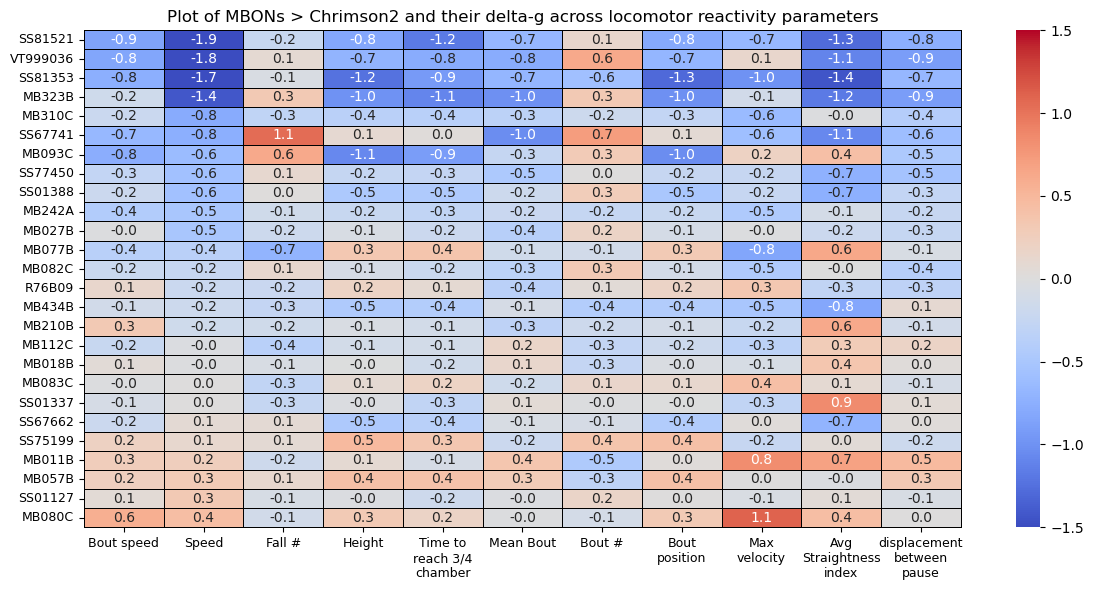

In [7]:
df5 = dfreg2.set_index(['MBON'])
fig, ax1 = plt.subplots(figsize=(12, 6))                
g1 = sns.heatmap(df5, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black', clip_on=False)
g1.set_ylabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation = 0, fontsize = 9)
g1.set_xticklabels(g1.get_xticklabels(), rotation = 0, fontsize = 9)
wrap_labels(g1, 10)
ax1.set_title('Plot of MBONs > ' + responder + ' and their delta-g across locomotor reactivity parameters')
fig.tight_layout()
#plt.savefig(openPath + "images\\deltagheatmap_8secondrule" + responder + "_" + date + ".png", dpi = 1200)

In [11]:
#delta and delta g heatmap
# 
dfreglist = [dfreg_bspeed.loc[dblist.index], dfreg_speed.loc[dblist.index], dfreg_fall.loc[dblist.index],dfreg_height.loc[dblist.index], dfreg_meanpause.loc[dblist.index], dfreg_pause.loc[dblist.index],dfreg_meanbout.loc[dblist.index], dfreg_bout.loc[dblist.index],dfreg_boutpos.loc[dblist.index], dfreg_pausepos.loc[dblist.index],dfreg_maxvelocity.loc[dblist.index],dfreg_straightindex.loc[dblist.index], dfreg_displacementbetweenpause.loc[dblist.index]]
totalregdf = pd.DataFrame()

for n,k in zip(dfreg2.columns, dfreglist):
    k.columns = pd.MultiIndex.from_product([[n], k.columns.tolist()])
    totalregdf = pd.concat([totalregdf, k], axis =1)


In [ ]:
import matplotlib.ticker as ticker
df0 = totalregdf.copy()
fig, ax2 = plt.subplots(figsize=(18, 6))                
y3 = sns.heatmap(df0, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='YlGnBu',clip_on=False) # linewidths=0.5, linecolor='black', 
y3.set_ylabel('')
y3.set_xticklabels('', rotation=0)
y3.set_xticklabels(['WT', 'Expt', 'Δg']*12, rotation=0)
#y3.set_yticklabels([dfreg2.columns], rotation = 0, fontsize = 9)

ax2.set_title('Plot of MBONs > ' + responder + ' and their delta-g across locomotor reactivity parameters')
ax2.vlines(list(range(3,3*12,3)), *ax2.get_xlim(), linewidth=3, color='k')

# for n,k in zip(dfreg2.columns[:-1], list(np.arange(1.35, 45, 3.25))):
#     nn = textwrap.fill(n,10)
#     y3.text((pos0 + pos1) / 2, 29, nn, ha = "center")
 
ax2.set_xticklabels(('WT', '\n\nAvg bout speed', 'Expt', 'Δg',
                     'WT','\n\nAvg speed',  'Expt', 'Δg',
                     'WT', '\n\nFall #','Expt', 'Δg',
                     'WT','\n\nAvg height', 'Expt', 'Δg',
                     'WT', '\n\nTime to reach 3/4 chamber', 'Expt', 'Δg',
                     'WT', '\n\nMean Bout time','Expt', 'Δg',
                     'WT', '\n\nBout #','Expt', 'Δg',
                     'WT', '\n\nAvg bout position','Expt', 'Δg',
                     'WT', '\n\nMax velocity','Expt', 'Δg',
                     'WT', '\n\nAvg straightness index','Expt', 'Δg',
                     'WT', '\n\ndisplacement between pause','Expt', 'Δg'), ha='center')



fig.tight_layout()

In [ ]:
def customwrap(s,width=30):
    return "<br>".join(textwrap.wrap(s,width=width))

In [25]:
# f1,ax = plt.subplots(nrows=1, ncols=13, sharex=False, sharey = True, figsize=(15, 6))

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

subplottitles = list(map(lambda s:s.replace('\n', ''), dfreg2.columns))
g1 = round(totalregdf,1)

fig = make_subplots(rows = 1,cols = 13, horizontal_spacing = 0.015, shared_yaxes =True, subplot_titles= dfreg2.columns)   


for n, j in zip(dfreg2.columns, list(range(1,14))):
    #g2 = g1[n].map(customwrap)
    print(g1[n])
    figure1 = px.imshow(g2, text_auto = True, aspect = "auto")
    fig.add_trace(figure1['data'][0], row = 1, col = j)


# fig.update_layout(title = 'Plot of MBONs > <b>' + responder +  '</b> and their cohens d, Δg across locomotor reactivity parameters', height = 1000, width = 1500)
# fig.update_annotations(font_size=12, yshift = -900)
# # wrap_labels(fig, 10)

# fig.write_image(openPath + "images\\"  + "cohens d and delta gheatmap_8secondrule" + responder + "_" + date + ".png")

# fig.show()

           WT  Expt  delta_g
MBON                        
SS81521   0.1  -0.7     -0.9
VT999036  0.4  -0.5     -0.8
SS81353   0.1  -0.7     -0.8
MB323B    0.1  -0.1     -0.2
MB310C    0.3   0.1     -0.2
SS67741   0.1  -0.3     -0.7
MB093C    0.3  -0.6     -0.8
SS77450  -0.0  -0.4     -0.3
SS01388   0.1  -0.1     -0.2
MB242A    0.5   0.1     -0.4
MB027B    0.2   0.2     -0.0
MB077B    0.3  -0.1     -0.4
MB082C    0.0  -0.3     -0.2
R76B09    0.1   0.2      0.1
MB434B    0.4   0.3     -0.1
MB210B    0.3   0.5      0.3
MB112C    0.4   0.2     -0.2
MB018B    0.2   0.2      0.1
MB083C    0.1   0.1     -0.0
SS01337  -0.2  -0.3     -0.1
SS67662   0.3   0.1     -0.2
SS75199   0.1   0.3      0.2
MB011B    0.0   0.3      0.3
MB057B    0.1   0.4      0.2
SS01127  -0.1  -0.1      0.1
MB080C    0.0   0.6      0.6


NameError: name 'g2' is not defined